In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from pykalman import KalmanFilter
except ImportError as e:
    !pip install pykalman
    from pykalman import KalmanFilter

import pandas as pd

# Data Generation

In [2]:
const_acceleration_x = 2
const_acceleration_y = 1
dt=0.0001
t= np.arange(0, 1.01, dt)
N = len(t)
traj = (2*(t**5)- 1.5*(t**4) + 0.05*(t**3) - 3*(t**2)+3*t)

t= (t)*100
traj= (traj)*100

In [3]:
def get_x_y_velocities(t,x, dt):
  
    x_velocities = np.zeros(len(t))
    y_velocities = np.zeros(len(t))
    np.random.seed(25)
    sigma = 0.4
    mu = 0 
    
    for i in range(1,len(t)) :
        
        noise = np.random.normal(loc = mu, scale = sigma)
        
        x_velocities[i] = ( t[i] - (t[i-1]+ (1/2)*const_acceleration_x*dt**2)) + noise
        y_velocities[i] = ( x[i] - (x[i-1]+ (1/2)*const_acceleration_y*dt**2)) + noise
    
    return x_velocities, y_velocities

In [4]:
x_vel, y_vel = get_x_y_velocities(t, traj, dt)

In [5]:


# the velocity is the first derivative
#v_t = 3 - 6*t + 0.15*t**2 - 6*t**3 + 10*t*4

#acc = -6 + 0.3 * t - 18 * t**2 + 40*t**3
#mean_acc = abs(np.mean(acc))
#print(mean_acc)
#a_t =  [mean_acc for _ in range(len(t))]


measurements = pd.DataFrame()
measurements['x_pos']= t
measurements['y_pos']= traj
measurements['x_vel']= x_vel
measurements['y_vel']= y_vel

measurements.head(20)


,x_pos,y_pos,x_vel,y_vel
0,0.00,0.000000,0.000000,0.000000
1,0.01,0.029997,0.101309,0.121306
2,0.02,0.059988,0.420756,0.440747
3,0.03,0.089973,-0.325834,-0.305849
4,0.04,0.119952,-0.226473,-0.206494
...,...,...,...,...
1005,10.05,27.111749,-0.459423,-0.445486
1006,10.06,27.135680,0.008018,0.021949
1007,10.07,27.159605,0.068168,0.082093
1008,10.08,27.183524,0.870547,0.884466


We want to predict the position of a moving object based on the current information of the object. For simplicity we assume a constant acceleration model for our problem.
The dynamics of a moving object in one dimension:

$$ x_t = \frac{1}{2}\ddot{x}T^2 + v_{t-1} + x_{t-1} $$
$$ v_t = \ddot{x}T + v_{t-1}$$

In we can extend the previous equations can be described by $x,y, \dot{x}, \dot{y}, \ddot{x}, \ddot{y} $

$$
X_{t} = \begin{bmatrix} 
x_t\\ 
y_t\\
\dot{x}\\
\dot{y}\\
\ddot{x}\\
\ddot{y}
\end{bmatrix}
$$

In [6]:
def plot_measurements(measurements):
    
    x_moon, y_moon = measurements.x_pos[len(measurements.x_pos)-1],  measurements.y_pos[len(measurements.y_pos)-1]
    x_earth, y_earth = measurements.x_pos[0], measurements.y_pos[0]
    
    plt.figure(figsize=(13,10))
    plt.plot(measurements.x_pos, measurements.y_pos, ls = "--",c='black', label = "Target Trajectoy")
    
    plt.title("Target Trajectory", fontsize=15)
    earth = plt.Circle(( x_earth, y_earth), 3, color='blue', label = "Earth", hatch='O')
    moon  = plt.Circle((x_moon, y_moon ), 1.5, color='grey', label = "Moon", hatch='O')
   
    moon = plt.gca().add_artist(moon)
    earth = plt.gca().add_artist(earth)
    
    legend_earth = plt.Line2D([0], [0], ls='None', color="blue", marker='o')
    legend_moon = plt.Line2D([0], [0], ls='None', color="grey", marker='o')
    legend_trajectory = plt.Line2D([0], [0], ls='--', color="black")
    plt.legend([legend_earth, legend_moon, legend_trajectory],["Earth","Moon","Target_Trajectory"])

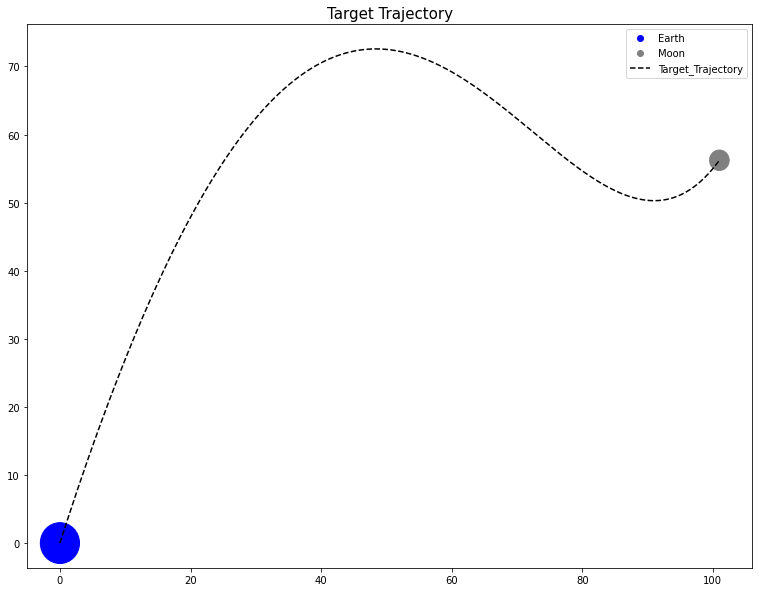

In [7]:
plot_measurements(measurements)

### Adding Position Noise

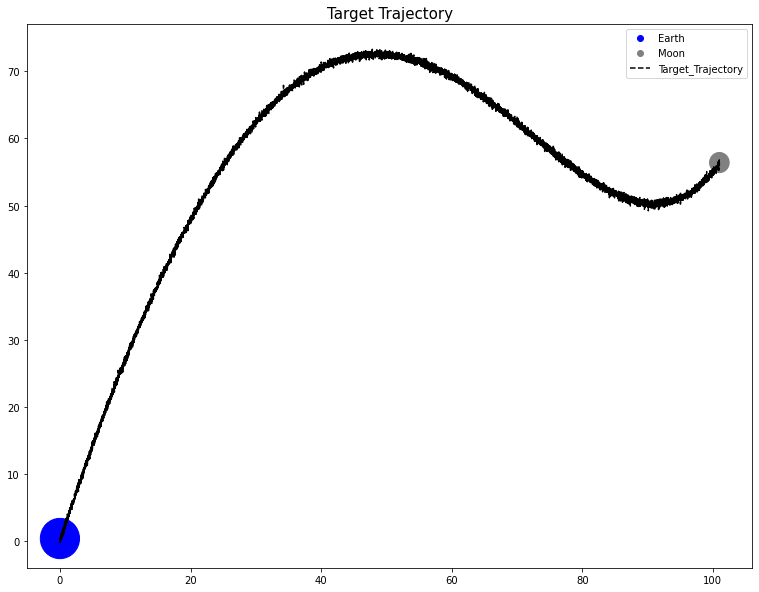

In [8]:
sigma_pos = 0.3
mu_pos = 0

np.random.seed(24)

noise_t = np.random.normal(loc = mu_pos, scale = sigma_pos, size=N)

traj_noisy = traj+noise_t

measurements["y_pos"] = traj_noisy

plot_measurements(measurements)

# Kalman Filtering

In order to compute the transition matrix we have to consider:

$$x_t = x_{t-1} + \dot{x}_{t-1} + \frac{1}{2}\ddot{x}\Delta t^2$$
$$y_t = y_{t-1} + \dot{y}_{t-1} + \frac{1}{2}\ddot{y}\Delta t^2$$
$$\dot{x}_t = \dot{x}_{t-1} + \ddot{x}\Delta t $$
$$\dot{y}_t = \dot{y}_{t-1} + \ddot{y}\Delta t $$

Assuming that the acceleration is constant, the transition matrix will be:

In [9]:
#Transition_Matrix matrix
PHI =   np.array([[1, 0, dt, 0, (dt**2)/2, 0],
                 [0, 1, 0, dt, 0, (dt**2)/2],
                 [0, 0, 1,  0, dt,0,],
                 [0, 0, 0,  1, 0, dt],
                 [0, 0, 0,  0,  1 , 0],
                 [0, 0, 0,  0,  0 , 1] ])

print("PHI: ", PHI.shape)
# Matrix Observation_Matrix
#We are looking for the position of the spaceship
H = np.array([[1,0,0,0,0,0],
             [0,1,0,0,0,0]])


#initial state
s = np.array([measurements.x_pos[0], measurements.y_pos[0], 
              measurements.x_vel[0], measurements.y_vel[0], const_acceleration_x, const_acceleration_y])


# Covariance
R = np.eye(2)* sigma_pos**2
print("Observation Covariance: \n", R,"\n\n")

init_covariance = np.eye(6) * sigma_pos**2

Dyn_Noise_Variance = (0.01)**2;
G = np.array([ [(dt**2)/2],
                [(dt**2)/2],
                [    dt   ],
                [    dt   ],
                [    1    ],
                [    1    ]])


Q = G * G.T * Dyn_Noise_Variance
print("Transition Covariance: \n", Q, "\n\n")

PHI:  (6, 6)
Observation Covariance: 
 [[0.09 0.  ]
 [0.   0.09]] 


Transition Covariance: 
 [[2.5e-21 2.5e-21 5.0e-17 5.0e-17 5.0e-13 5.0e-13]
 [2.5e-21 2.5e-21 5.0e-17 5.0e-17 5.0e-13 5.0e-13]
 [5.0e-17 5.0e-17 1.0e-12 1.0e-12 1.0e-08 1.0e-08]
 [5.0e-17 5.0e-17 1.0e-12 1.0e-12 1.0e-08 1.0e-08]
 [5.0e-13 5.0e-13 1.0e-08 1.0e-08 1.0e-04 1.0e-04]
 [5.0e-13 5.0e-13 1.0e-08 1.0e-08 1.0e-04 1.0e-04]] 




In [10]:
kf = KalmanFilter(transition_matrices=PHI,
                  observation_matrices=H,
                  initial_state_mean=s,
                  initial_state_covariance=init_covariance)

In [11]:
#kf = kf.em(measurements[["x_pos","y_pos"]], n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements[["x_pos","y_pos"]])

<Figure size 864x576 with 0 Axes>

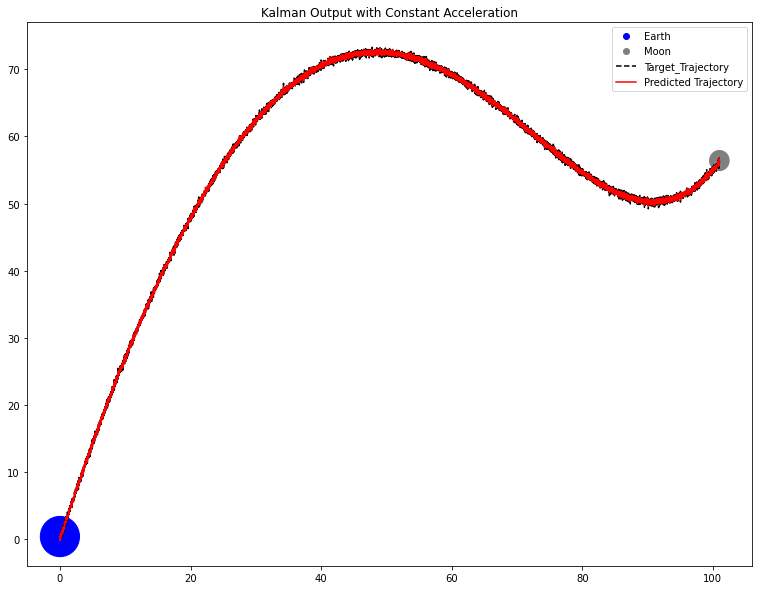

In [12]:
plt.figure(figsize=(12,8))
plot_measurements(measurements)
plt.plot(filtered_state_means[:,0],filtered_state_means[:,1],c='r',label='kalman output')
plt.title("Kalman Output with Constant Acceleration")


legend_earth = plt.Line2D([0], [0], ls='None', color="blue", marker='o')
legend_moon = plt.Line2D([0], [0], ls='None', color="grey", marker='o')
legend_trajectory = plt.Line2D([0], [0], ls='--', color="black")
predicted_trajectory = plt.Line2D([0], [0], color="r")
plt.legend([legend_earth, legend_moon, legend_trajectory, predicted_trajectory],["Earth","Moon","Target_Trajectory","Predicted Trajectory"])

## FILTERPY

In [13]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Saver

In [14]:
""" :dt = time step """
def Ship_tracker(dt):
    tracker= KalmanFilter(dim_x = 6, dim_z=2)
    tracker.x = s

    tracker.F = PHI
    tracker.H = H   # Measurement function
    tracker.P = np.eye(6)*500   # covariance matrix
    tracker.R = R  # state uncertainty
    tracker.Q =  Q # process uncertainty
    return tracker

In [15]:
tracker = Ship_tracker(dt)

In [16]:
zs = measurements[["x_pos","y_pos"]].to_numpy()

def run(tracker, zs):
    
    preds, cov = [],[]
    for z in zs:
        
        tracker.predict()
        tracker.update(z=z)
        
        preds.append(tracker.x)
        cov.append(tracker.P)
    
    return np.array(preds), np.array(cov)

preds, cov = run(tracker, zs)

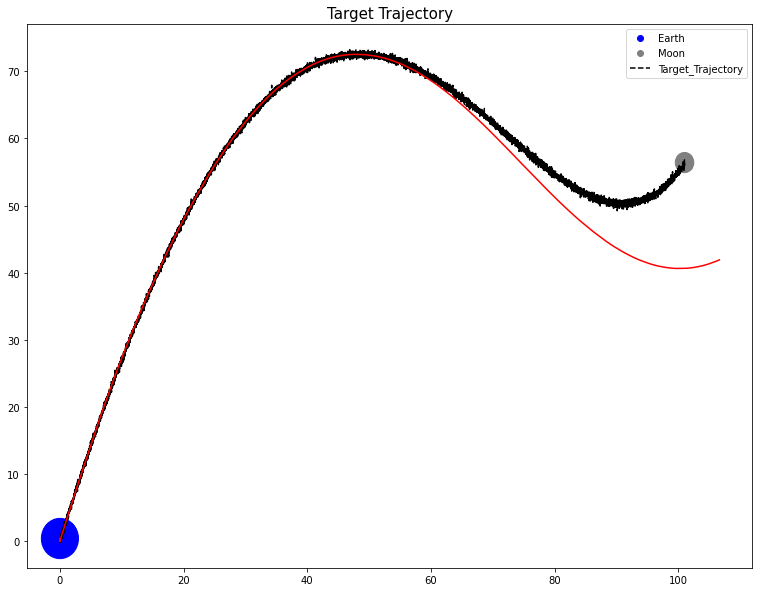

In [17]:
plot_measurements(measurements)
plt.plot(preds[:,0], preds[:,1], c="r")